# Cross-Language MFD Validation

This notebook validates that the Tamil and Kannada translations of the Moral Foundations Dictionary preserve semantic similarity with the original English version.

## Load MFD dictionaries for all three languages

In [1]:
import pickle
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns

/Users/devisivakumar/MyWorkspace/ANLP_Project/anlp-project/venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Load English MFD

In [2]:
# Load English MFD
MFD2 = 'mfd2.0.dic'
nummap = dict()
mfd2_english = dict()
wordmode = True

with open(MFD2, 'r') as f:
    for line in f.readlines():
        ent = line.strip().split()
        if line[0] == '%':
            wordmode = not wordmode
        elif len(ent) > 0:
            if wordmode:
                moral = nummap[ent[-1]]
                if (moral not in mfd2_english.keys()):
                    mfd2_english[moral] = []
                mfd2_english[moral].append(''.join([e for e in ent if e not in nummap.keys()]))
            else:
                nummap[ent[0]] = ent[1]

print("English MFD loaded:")
for foundation, words in mfd2_english.items():
    print(f"  {foundation}: {len(words)} words")

English MFD loaded:
  care.virtue: 182 words
  care.vice: 288 words
  fairness.virtue: 115 words
  fairness.vice: 236 words
  loyalty.virtue: 143 words
  loyalty.vice: 49 words
  authority.virtue: 301 words
  authority.vice: 130 words
  sanctity.virtue: 272 words
  sanctity.vice: 388 words


### Load Kannada MFD

In [3]:
# Load Kannada translated dictionary
with open('kannada_mfd.pkl', 'rb') as f:
    mfd2_kannada = pickle.load(f)

print("Kannada MFD loaded:")
for foundation, words in mfd2_kannada.items():
    print(f"  {foundation}: {len(words)} words")

Kannada MFD loaded:
  care.virtue: 182 words
  care.vice: 288 words
  fairness.virtue: 115 words
  fairness.vice: 236 words
  loyalty.virtue: 143 words
  loyalty.vice: 49 words
  authority.virtue: 301 words
  authority.vice: 130 words
  sanctity.virtue: 272 words
  sanctity.vice: 388 words


### Load Tamil MFD

In [4]:
# Load Tamil translated dictionary
with open('tamil_mfd.pkl', 'rb') as f:
    mfd2_tamil = pickle.load(f)

print("Tamil MFD loaded:")
for foundation, words in mfd2_tamil.items():
    print(f"  {foundation}: {len(words)} words")

Tamil MFD loaded:
  care.virtue: 182 words
  care.vice: 288 words
  fairness.virtue: 115 words
  fairness.vice: 236 words
  loyalty.virtue: 142 words
  loyalty.vice: 49 words
  authority.virtue: 301 words
  authority.vice: 130 words
  sanctity.virtue: 272 words
  sanctity.vice: 388 words


## Generate Embeddings for All Languages

We use the same multilingual model (`l3cube-pune/indic-sentence-similarity-sbert`) to ensure embeddings are in the same semantic space.

In [5]:
# Load multilingual embedding model
EMBEDDINGS_MODEL_NAME = 'l3cube-pune/indic-sentence-similarity-sbert'
model = SentenceTransformer(EMBEDDINGS_MODEL_NAME)
print(f"Loaded model: {EMBEDDINGS_MODEL_NAME}")

Loaded model: l3cube-pune/indic-sentence-similarity-sbert


In [6]:
# Generate embeddings for English
print("Generating English embeddings...")
word_embeddings_english = {}
for foundation, words in mfd2_english.items():
    word_embeddings_english[foundation] = model.encode(words)
print("✓ English embeddings done")

# Generate embeddings for Kannada
print("Generating Kannada embeddings...")
word_embeddings_kannada = {}
for foundation, words in mfd2_kannada.items():
    word_embeddings_kannada[foundation] = model.encode(words)
print("✓ Kannada embeddings done")

# Generate embeddings for Tamil
print("Generating Tamil embeddings...")
word_embeddings_tamil = {}
for foundation, words in mfd2_tamil.items():
    word_embeddings_tamil[foundation] = model.encode(words)
print("✓ Tamil embeddings done")

Generating English embeddings...
✓ English embeddings done
Generating Kannada embeddings...
✓ Kannada embeddings done
Generating Tamil embeddings...
✓ Tamil embeddings done


## Calculate Master Moral Vectors for Each Language

In [7]:
# Calculate master moral vectors for English
master_vectors_english = {}
for foundation, embeddings in word_embeddings_english.items():
    master_vectors_english[foundation] = np.mean(embeddings, axis=0)

# Calculate master moral vectors for Kannada
master_vectors_kannada = {}
for foundation, embeddings in word_embeddings_kannada.items():
    master_vectors_kannada[foundation] = np.mean(embeddings, axis=0)

# Calculate master moral vectors for Tamil
master_vectors_tamil = {}
for foundation, embeddings in word_embeddings_tamil.items():
    master_vectors_tamil[foundation] = np.mean(embeddings, axis=0)

print("Master moral vectors calculated for all languages")

Master moral vectors calculated for all languages


## Compute Cross-Language Similarity

We calculate cosine similarity between master moral vectors across languages.

In [9]:
# Get foundation names in order
foundations = list(mfd2_english.keys())

# Calculate cosine similarities
similarities = {
    'English-Kannada': [],
    'English-Tamil': [],
    'Kannada-Tamil': []
}

for foundation in foundations:
    vec_en = master_vectors_english[foundation].reshape(1, -1)
    vec_kn = master_vectors_kannada[foundation].reshape(1, -1)
    vec_ta = master_vectors_tamil[foundation].reshape(1, -1)
    
    sim_en_kn = cosine_similarity(vec_en, vec_kn)[0][0]
    sim_en_ta = cosine_similarity(vec_en, vec_ta)[0][0]
    sim_kn_ta = cosine_similarity(vec_kn, vec_ta)[0][0]
    
    similarities['English-Kannada'].append(sim_en_kn)
    similarities['English-Tamil'].append(sim_en_ta)
    similarities['Kannada-Tamil'].append(sim_kn_ta)

# Create DataFrame for better visualization
df_similarities = pd.DataFrame(similarities, index=foundations)
print("\nCosine Similarities Between Languages:")
print(df_similarities.round(4))

print("\nAverage Similarities:")
print(df_similarities.mean().round(4))


Cosine Similarities Between Languages:
                  English-Kannada  English-Tamil  Kannada-Tamil
care.virtue                0.9420         0.9364         0.9590
care.vice                  0.9255         0.9296         0.9554
fairness.virtue            0.9257         0.9353         0.9515
fairness.vice              0.9131         0.9233         0.9524
loyalty.virtue             0.9581         0.9498         0.9615
loyalty.vice               0.8614         0.8777         0.9210
authority.virtue           0.9419         0.9372         0.9619
authority.vice             0.8909         0.8858         0.9286
sanctity.virtue            0.9159         0.9108         0.9481
sanctity.vice              0.9077         0.9213         0.9512

Average Similarities:
English-Kannada    0.9182
English-Tamil      0.9207
Kannada-Tamil      0.9491
dtype: float32


## Visualize Cross-Language Similarities

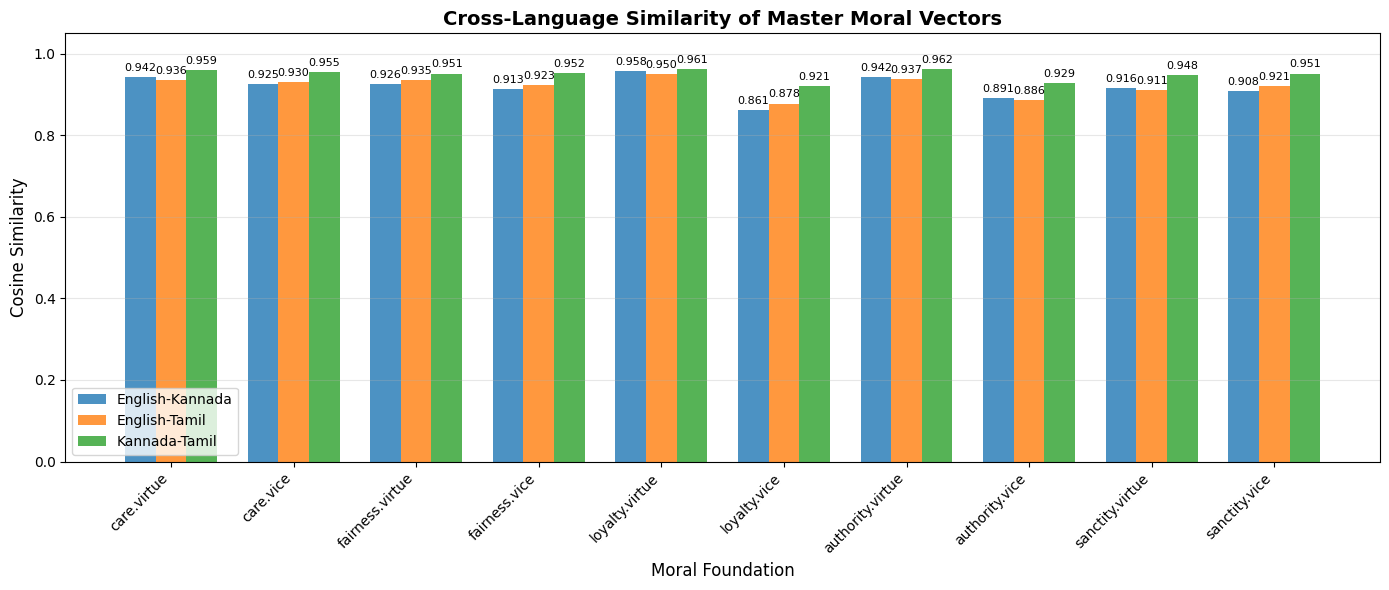

In [18]:
# Bar plot for similarity scores
fig, ax = plt.subplots(figsize=(14, 6))

x = np.arange(len(foundations))
width = 0.25

bars1 = ax.bar(x - width, df_similarities['English-Kannada'], width, label='English-Kannada', alpha=0.8)
bars2 = ax.bar(x, df_similarities['English-Tamil'], width, label='English-Tamil', alpha=0.8)
bars3 = ax.bar(x + width, df_similarities['Kannada-Tamil'], width, label='Kannada-Tamil', alpha=0.8)

# Add value labels on top of bars
ax.bar_label(bars1, fmt='%.3f', padding=3, fontsize=8)
ax.bar_label(bars2, fmt='%.3f', padding=3, fontsize=8)
ax.bar_label(bars3, fmt='%.3f', padding=3, fontsize=8)

ax.set_xlabel('Moral Foundation', fontsize=12)
ax.set_ylabel('Cosine Similarity', fontsize=12)
ax.set_title('Cross-Language Similarity of Master Moral Vectors', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(foundations, rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)
ax.set_ylim([0, 1.05])  # Increased to make room for labels

plt.tight_layout()
plt.show()

## Create Similarity Heatmap

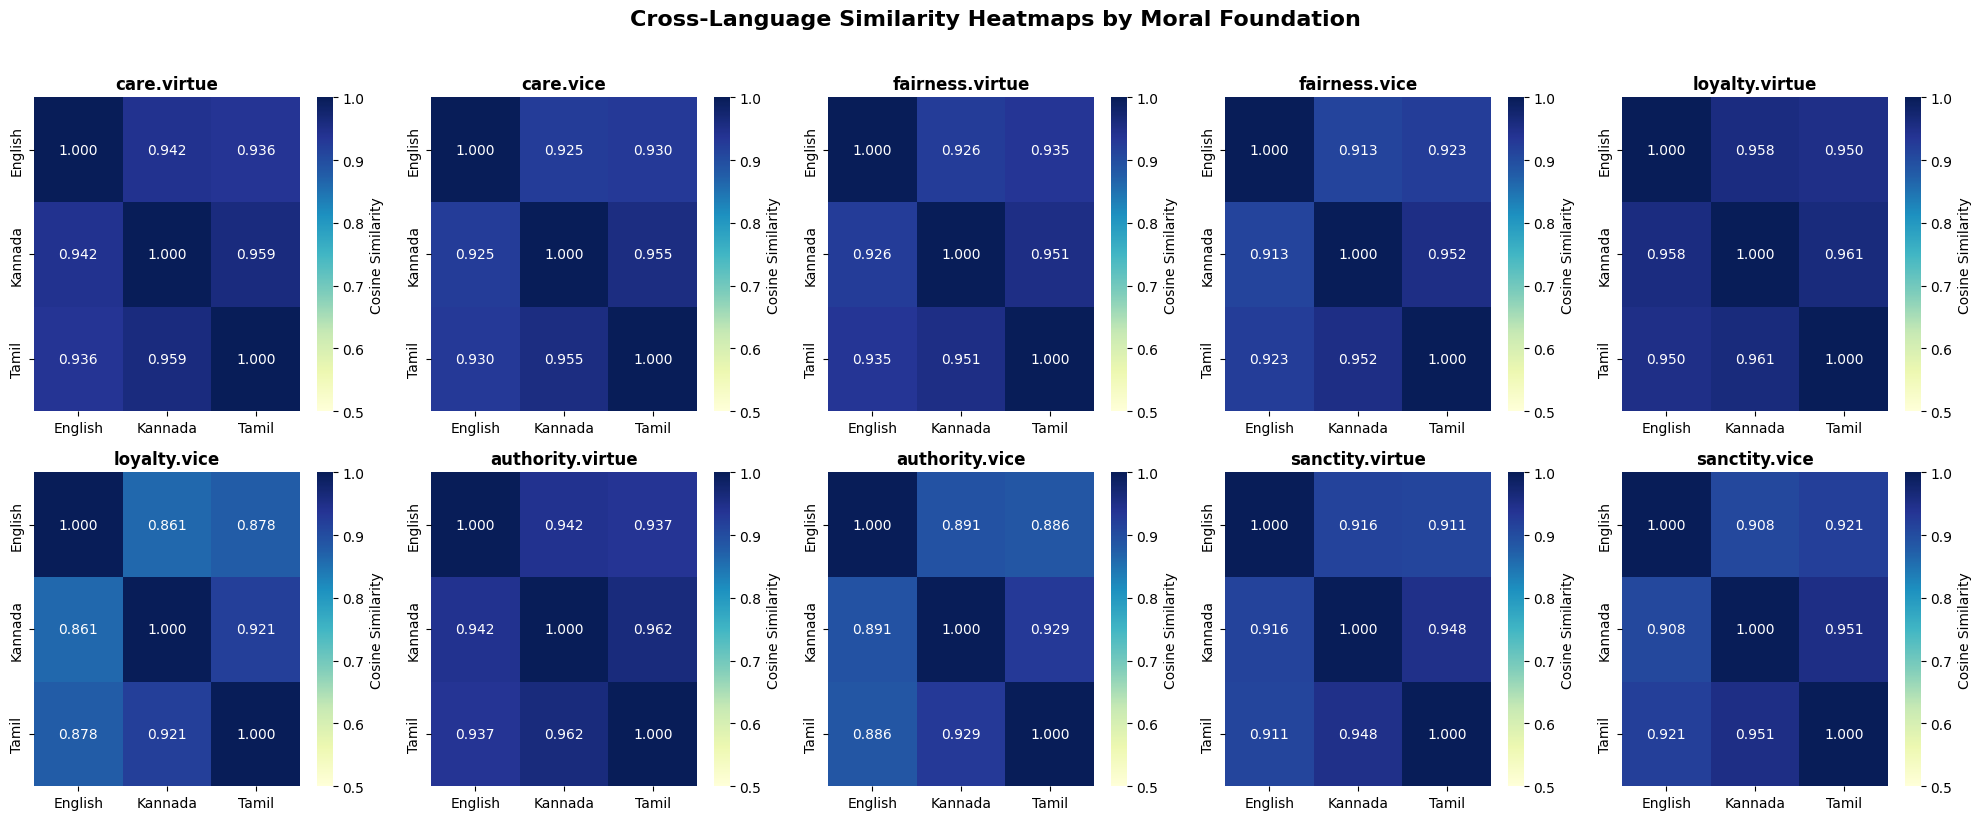

In [11]:
# Create a matrix of all pairwise similarities
languages = ['English', 'Kannada', 'Tamil']
all_master_vectors = [master_vectors_english, master_vectors_kannada, master_vectors_tamil]

# For each foundation, create a language similarity matrix
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.flatten()

for idx, foundation in enumerate(foundations):
    # Create similarity matrix for this foundation
    sim_matrix = np.zeros((3, 3))
    for i, lang1_vectors in enumerate(all_master_vectors):
        for j, lang2_vectors in enumerate(all_master_vectors):
            vec1 = lang1_vectors[foundation].reshape(1, -1)
            vec2 = lang2_vectors[foundation].reshape(1, -1)
            sim_matrix[i, j] = cosine_similarity(vec1, vec2)[0][0]
    
    # Plot heatmap
    sns.heatmap(sim_matrix, annot=True, fmt='.3f', cmap='YlGnBu', 
                xticklabels=languages, yticklabels=languages,
                vmin=0.5, vmax=1.0, ax=axes[idx], cbar_kws={'label': 'Cosine Similarity'})
    axes[idx].set_title(foundation, fontweight='bold')

plt.suptitle('Cross-Language Similarity Heatmaps by Moral Foundation', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()